# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from Food10)
import requests
import zipfile
import io
# Download the zip file using requests

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
response = requests.get(url)
# Unzip the file in memory and extract it

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall("pizza_steak")  # Extract to a folder called 'pizza_steak'

In [1]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('../data/10_food_classes_10_percent/'):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

there are 2 directories and 0 images in '../data/10_food_classes_10_percent/'
there are 10 directories and 0 images in '../data/10_food_classes_10_percent/test'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\chicken_curry'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\chicken_wings'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\fried_rice'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\grilled_salmon'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\hamburger'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\ice_cream'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\pizza'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\ramen'
there are 0 directories and 250 images in '../data/10_food_classes_10_percent/tes

## Creating data loader (preparing the data)


In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "../data/10_food_classes_10_percent/train/"
test_dir = "../data/10_food_classes_10_percent/test/"

train_data = image_dataset_from_directory(directory=train_dir,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE,
                                          image_size=IMAGE_SHAPE,
                                          seed=42)

test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SHAPE,
                                         seed=42)

# Нормализация входных данных
normalization_layer = layers.Rescaling(1./255)

# Применяем нормализацию к данным
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.



## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoin with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [3]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")

    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've use TensorFlow to create our own models layers by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come fro TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://www.kaggle.com/models/google/resnet-v2/tensorFlow2

In [4]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow import keras

In [6]:
import tf_keras as tfk

def create_model_from_a_url(url: str, num_classes=10):
    """
    Takes a tensorflow hub URL and creates a tensorflow Sequential model with it.
    Returns:
        -> an uncompiled model
    """
    feature_extractor_layer = hub.KerasLayer(
        url,
        trainable=False,
        name="feature_extraction_layer",
        input_shape=IMAGE_SHAPE + (3,)
    )
    print(" ")
    print(feature_extractor_layer)
    print(" ")

    model = keras.Sequential([
        feature_extractor_layer,
        keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [7]:
# Create Resnet model
resnet_model = create_model_from_a_url(url=resnet_url, num_classes=10)
resnet_model.build((None,) + IMAGE_SHAPE + (3,))
resnet_model.summary()

 
 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [8]:
# Compile our resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [9]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250325-233521
Epoch 1/5



24/24 [==============================] - 111s 5s/step - loss: 1.8528 - accuracy: 0.3813 - val_loss: 1.1779 - val_accuracy: 0.6176
Epoch 2/5
24/24 [==============================] - 117s 5s/step - loss: 0.8685 - accuracy: 0.7347 - val_loss: 0.8501 - val_accuracy: 0.7228
Epoch 3/5
24/24 [==============================] - 113s 5s/step - loss: 0.6129 - accuracy: 0.8187 - val_loss: 0.7648 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 113s 5s/step - loss: 0.4682 - accuracy: 0.8853 - val_loss: 0.6841 - val_accuracy: 0.7876
Epoch 5/5
24/24 [==============================] - 121s 5s/step - loss: 0.3591 - accuracy: 0.9080 - val_loss: 0.6621 - val_accuracy: 0.7812


In [10]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 85s 1s/step - loss: 0.6621 - accuracy: 0.7812


[0.6620907783508301, 0.7811999917030334]

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we build by hand... (substantially) and in a quicker training time AND with only 10% of the training examples

In [12]:
import matplotlib.pyplot as plt

# Let's create a function to plot our loss curves....
# Tidbit: you could put a function like this into a script called 'helper.py' and import it when you need it...

# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training ans validation metrics.

    Args:
      history: TensorFlow History object.

    Returns:
      Plots of training/validation loss and accuracy metrics.
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history["loss"])) # how many epochs did we run for?

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend();

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend();

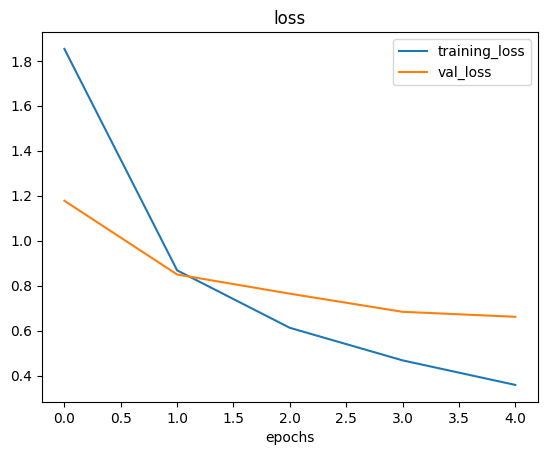

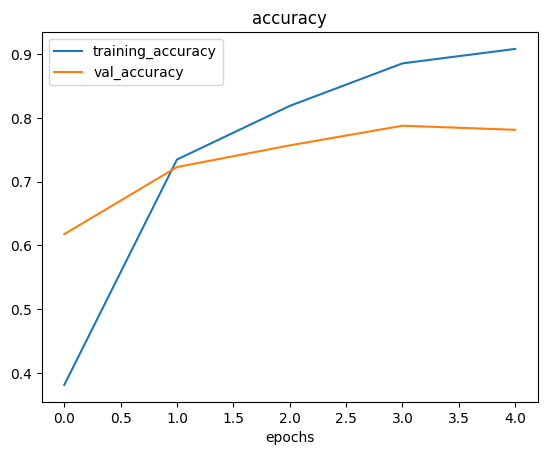

In [13]:
plot_loss_curves(resnet_history)